In [60]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
nmeasurements = 72 # The number of experimental measurements
sigma_true = 3.0 # stddev of normal distribution from which true data is generated
rmse_true = 1.0 # true RMSE of computation compared to experiment
sigma_exp = 0.3 # stddev of random error added onto experiments due to experimental error sources
sigma_calc = 0.2 # stddev of random error added onto true computed value due to finite sample sizes

In [62]:
# Generate an experimental dataset
# You can play with the default parameters below
def generate_dataset(nmeasurements, sigma_true, rmse_true, sigma_exp, sigma_calc):
    """
    Generate an experimental dataset (and corresponding true values) by drawing from the true distribution of data.
    
    A set of `nmeasurements` true data values is generated from
    
    x_true[n] ~ N(0, sigma_true^2)   n = 1..nmeasurements
    
    from which experimental and calculated values are computed as
    
    x_exp[n] ~ N(x_true[n], sigma_exp^2)
    x_calc_true[n] ~ N(xtrue[n], rmse_true^2)
    x_calc[n] ~ N(xcalctrue[n], sigma_calc^2)    
    
    Parameters
    ----------
    nmeasurements : int
        The number of experimental measurements
    sigma_true : float
        stddev of normal distribution from which true data is generated
    rmse_true : float
        true RMSE of computation compared to experiment
    sigma_exp : float
        stddev of random error added onto experiments due to experimental error sources
    sigma_calc : float
        stddev of random error added onto true computed value due to finite sample sizes
        
    Returns
    -------
    x_true : float array of size [nmeasurements]
        True data values        
    x_calc_true : float array of size [nmeasurements]
        True calculated data values
    x_exp : float array of size [nmeasurements]
        Experimental measurements corrupted with noise
    x_calc : float array of size [nmeasurements]
        Calculated values corrupted with noise
    
    """
    x_true = sigma_true * np.random.randn(nmeasurements)
    x_calc_true = x_true + rmse_true * np.random.randn(nmeasurements)
    x_exp = x_true + sigma_exp * np.random.randn(nmeasurements)
    x_calc = x_calc_true + sigma_calc * np.random.randn(nmeasurements)

    return [x_true, x_calc_true, x_exp, x_calc]

In [63]:
# Define some statistical functions we're concerned about
def mue(x, y):
    return np.mean(abs(x - y))

def rmse(x, y):
    return np.sqrt(np.mean((x - y)**2))    

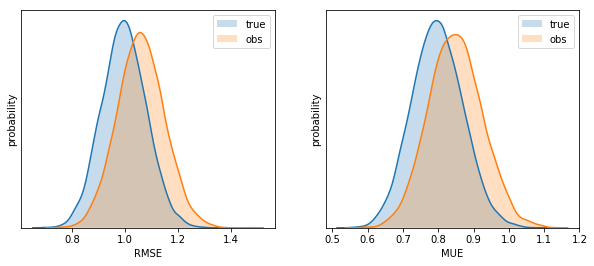

In [64]:
# Geneate some datasets and compile statistics
nreplicates = 10000
rmse_true_n = np.zeros([nreplicates])
rmse_obs_n = np.zeros([nreplicates])
mue_true_n = np.zeros([nreplicates])
mue_obs_n = np.zeros([nreplicates])
for replicate in range(nreplicates):
    x_true, x_calc_true, x_exp, x_calc = generate_dataset(nmeasurements, sigma_true, rmse_true, sigma_exp, sigma_calc)
    mue_true_n[replicate] = mue(x_true, x_calc_true)
    mue_obs_n[replicate] = mue(x_exp, x_calc)
    rmse_true_n[replicate] = rmse(x_true, x_calc_true)
    rmse_obs_n[replicate] = rmse(x_exp, x_calc)

# Plot
plt.figure(figsize=[10,4]);

# RMSE
plt.subplot(121);
sns.kdeplot(rmse_true_n, shade=True);
sns.kdeplot(rmse_obs_n, shade=True);
plt.legend(['true', 'obs']);
plt.xlabel('RMSE');
plt.ylabel('probability');
plt.yticks([]);

# MUE
plt.subplot(122);
sns.kdeplot(mue_true_n, shade=True);
sns.kdeplot(mue_obs_n, shade=True);
plt.legend(['true', 'obs']);
plt.xlabel('MUE');
plt.ylabel('probability');
plt.yticks([]);


In [73]:
def bootstrap_error(x_true, x_calc_true, x_exp, x_calc, sigma_exp, sigma_calc, nbootstrap=10000):
    """
    Define a bootstrap procedure to analyze a single experimental dataset by just adding experimental noise
    but not bootstrapping over data to see if we can estimate the true sample RMSE and MUE (but not global RMSE and MUE).
    
    Parameters
    ----------
    x_true : float array of size [nmeasurements]
        True data values        
    x_calc_true : float array of size [nmeasurements]
        True calculated data values
    x_exp : float array of size [nmeasurements]
        Experimental measurements corrupted with noise
    x_calc : float array of size [nmeasurements]
        Calculated values corrupted with noise
    sigma_exp : float
        stddev of random error added onto experiments due to experimental error sources
    sigma_calc : float
        stddev of random error added onto true computed value due to finite sample sizes
        
    """
    mue_bootstrap_n = np.zeros([nbootstrap])
    rmse_bootstrap_n = np.zeros([nbootstrap])
    for replicate in range(nbootstrap):
        x_exp_bootstrap = x_exp * sigma_exp * np.random.randn(nmeasurements)
        x_calc_bootstrap = x_calc * sigma_calc * np.random.randn(nmeasurements)
        mue_bootstrap_n[replicate] = mue(x_exp_bootstrap, x_calc_bootstrap)
        rmse_bootstrap_n[replicate] = rmse(x_exp_bootstrap, x_calc_bootstrap)

    true_sample_rmse = rmse(x_true, x_calc_true)
    true_sample_mue = mue(x_true, x_calc_true)
    
    # Plot
    plt.figure(figsize=[10,4]);

    # RMSE
    plt.subplot(121);
    sns.kdeplot(rmse_bootstrap_n, shade=True);
    plt.plot([true_sample_rmse, true_sample_rmse], [0, 10], 'k-');
    plt.legend(['bootstrap', 'true sample']);
    plt.xlabel('RMSE');
    plt.ylabel('probability');
    plt.yticks([]);

    # MUE
    plt.subplot(122);
    sns.kdeplot(mue_bootstrap_n, shade=True);
    plt.plot([true_sample_mue, true_sample_mue], [0, 10], 'k-');
    plt.legend(['bootstrap', 'true sample']);
    plt.xlabel('MUE');
    plt.ylabel('probability');
    plt.yticks([]);   

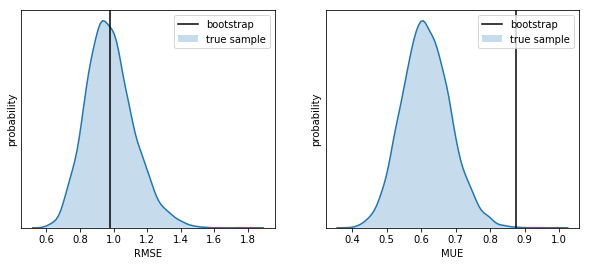

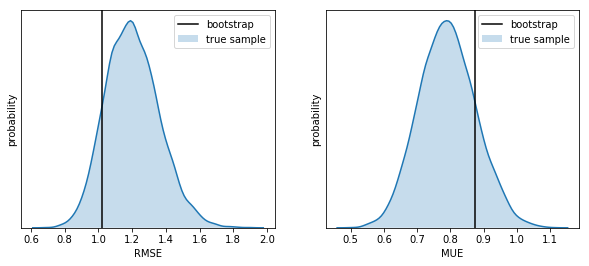

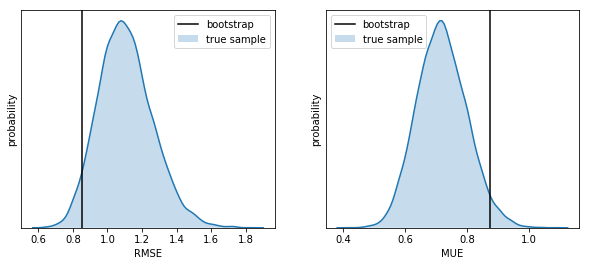

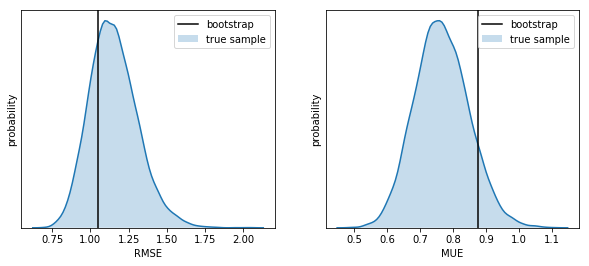

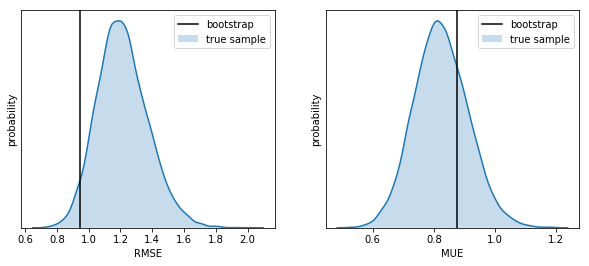

In [72]:
for example in range(5):
    x_true, x_calc_true, x_exp, x_calc = generate_dataset(nmeasurements, sigma_true, rmse_true, sigma_exp, sigma_calc)
    bootstrap_error(x_true, x_calc_true, x_exp, x_calc, sigma_exp, sigma_calc)

In [78]:
def bootstrap_error_and_sample(x_true, x_calc_true, x_exp, x_calc, sigma_exp, sigma_calc, sigma_true, rmse_true, nbootstrap=10000):
    """
    Define a bootstrap procedure to analyze a single experimental dataset by both bootstrapping over measurements
    and adding experimental noise to see if we can estimate the global sample RMSE and MUE.
    
    Parameters
    ----------
    x_true : float array of size [nmeasurements]
        True data values        
    x_calc_true : float array of size [nmeasurements]
        True calculated data values
    x_exp : float array of size [nmeasurements]
        Experimental measurements corrupted with noise
    x_calc : float array of size [nmeasurements]
        Calculated values corrupted with noise
    sigma_exp : float
        stddev of random error added onto experiments due to experimental error sources
    sigma_calc : float
        stddev of random error added onto true computed value due to finite sample sizes
    sigma_true : float
        stddev of normal distribution from which true data is generated
    rmse_true : float
        true RMSE of computation compared to experiment        
        
    """
    mue_bootstrap_n = np.zeros([nbootstrap])
    rmse_bootstrap_n = np.zeros([nbootstrap])
    for replicate in range(nbootstrap):
        indices = np.random.choice(range(nmeasurements), size=nmeasurements)
        x_exp_bootstrap = x_exp[indices] * sigma_exp * np.random.randn(nmeasurements)
        x_calc_bootstrap = x_calc[indices] * sigma_calc * np.random.randn(nmeasurements)
        mue_bootstrap_n[replicate] = mue(x_exp_bootstrap, x_calc_bootstrap)
        rmse_bootstrap_n[replicate] = rmse(x_exp_bootstrap, x_calc_bootstrap)
        
    # Estimate the true MUE via a very large sample
    x = sigma_true * np.random.randn(10000)
    y = x + rmse_true * np.random.randn(10000)
    true_mue = mue(x, y)
    
    # Plot
    plt.figure(figsize=[10,4]);

    # RMSE
    plt.subplot(121);
    sns.kdeplot(rmse_bootstrap_n, shade=True);
    plt.plot([true_rmse, true_rmse], [0, 10], 'k-');
    plt.legend(['bootstrap', 'true global']);
    plt.xlabel('RMSE');
    plt.ylabel('probability');
    plt.yticks([]);

    # MUE
    plt.subplot(122);
    sns.kdeplot(mue_bootstrap_n, shade=True);
    plt.plot([true_mue, true_mue], [0, 10], 'k-');
    plt.legend(['bootstrap', 'true global']);
    plt.xlabel('MUE');
    plt.ylabel('probability');
    plt.yticks([]);   

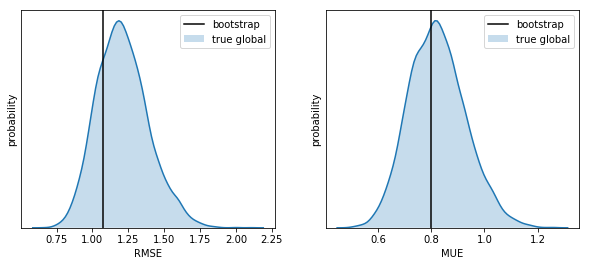

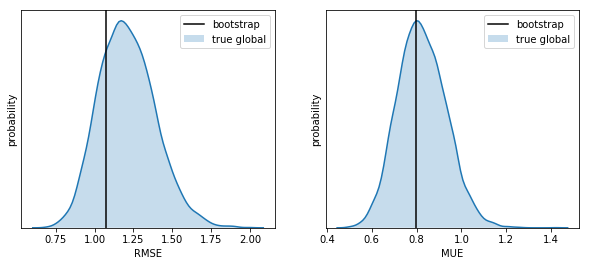

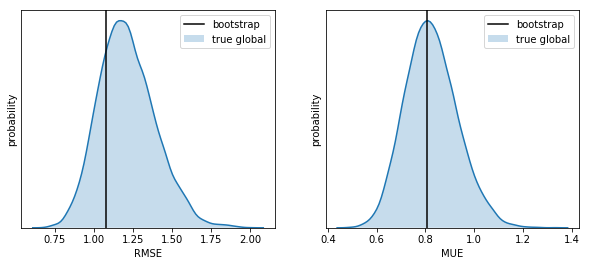

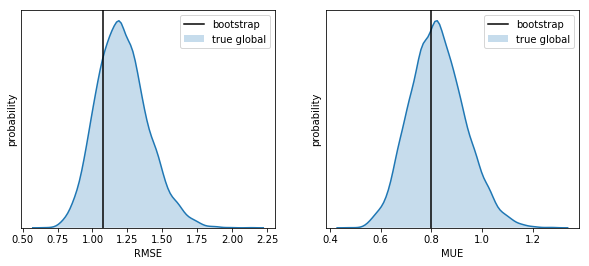

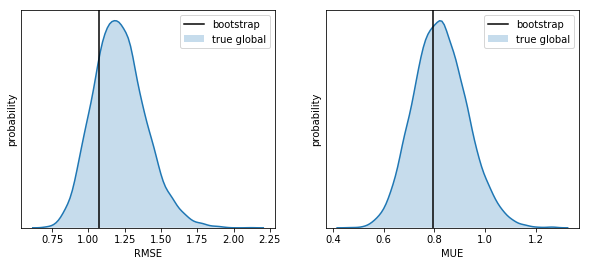

In [79]:
for example in range(5):
    bootstrap_error_and_sample(x_true, x_calc_true, x_exp, x_calc, sigma_exp, sigma_calc, sigma_true, rmse_true)